In [1]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import matplotlib.pyplot as plt
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()

"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [2]:
env = wrap_env(gym.make("Switch2-v0")) # Use "Switch4-v0" for the Switch-4 game
done_n = [False for _ in range(env.n_agents)]
ep_reward = 0

obs_n = env.reset()
while not all(done_n):
    obs_n, reward_n, done_n, info = env.step(env.action_space.sample())
    ep_reward += sum(reward_n)
    env.render()
env.close()
# To improve the training efficiency, render() is not necessary during the training.
# We provide the render and video code here just want to demonstrate how to debugging and analysis.
# show_video()

In [3]:
from collections import deque, namedtuple

import numpy as np
import random
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Transition = namedtuple(
            'transition', 
            ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, buffer_size: int) -> None:
        self.capacity = buffer_size

        # 用列表采样会更快，但是deque讲陈旧的样本推出队列，list做不到这样的功能
        self.memory = deque(maxlen=buffer_size)

    def __len__(self):
        return len(self.memory)

    def add(self, state: torch.tensor, action: torch.tensor, reward: torch.tensor, next_state: torch.tensor, done: bool) -> None:
        self.memory.append(Transition(
            state=state,
            action=action,
            reward=reward,
            next_state=next_state,
            done=done))

    def sample(self, batch_size: int):
        # Doesn't remove samples from memory
        return random.sample(self.memory, k=batch_size)


class DQN(nn.Module):
    def __init__(self, in_features, out_features, hidden_layers_size = 128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_layers_size)
        self.fc2 = nn.Linear(hidden_layers_size, hidden_layers_size // 2)
        self.fc3 = nn.Linear(hidden_layers_size // 2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
class DQNAgent:
    def __init__(
        self, 
        observation_space_dim: int, 
        n_actions: int,
        hidden_layers_size: int,
        buffer_size: int,
        batch_size: int,
        start_learning_steps: int,
        update_target_steps: int,
        agent_type:str,
        loss_func: str,
        learning_rate: float,
        clip_grads: bool,
        gamma: float,
        eps_start: float,
        eps_end: float,
        eps_decay_steps: int
    ):
        assert loss_func in ('mse', 'huber') #断言语句，返回bool型，为真时执行
        assert agent_type in ('dqn', 'ddqn')

        self.n_actions = n_actions        #初始化动作个数，传递值
        self.observation_space_dim = observation_space_dim    #状态观测空间的维数
        self.hidden_layers_size = hidden_layers_size          #隐藏层的大小 int型

        self.memory = ReplayBuffer(buffer_size)               #初始化经验池大小
        self.batch_size = batch_size                          #采样的大小
        self.start_learning_steps = start_learning_steps

        self.agent_type = agent_type
        self.loss_func = loss_func
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.clip_grads = clip_grads

        self.epsilon = eps_start
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay_steps = eps_decay_steps

        self.update_target_steps = update_target_steps
        self.timestep = 0

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.policy_net = DQN(in_features=observation_space_dim, out_features=n_actions,
                              hidden_layers_size=self.hidden_layers_size).to(self.device)
        self.target_net = DQN(in_features=observation_space_dim, out_features=n_actions,
                              hidden_layers_size=self.hidden_layers_size).to(self.device)

        # Set the target network's weights equal to our randomly initialised policy_net
        self._update_target_net()

        self.optimizer = optim.Adam(
            params=self.policy_net.parameters(),
            lr=self.learning_rate)

    def _store_transitions(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool):
        state_t = torch.tensor(state, dtype=torch.float, device=self.device)
        next_state_t = torch.tensor(next_state, dtype=torch.float, device=self.device)
        action_t = torch.tensor([action], dtype=torch.long, device=self.device)
        reward_t = torch.tensor([reward], dtype=torch.float, device=self.device)

        self.memory.add(state=state_t, action=action_t, reward=reward_t, next_state=next_state_t, done=done)

    def _update_epsilon(self):
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * \
                       np.exp(-1. * ((self.timestep - self.start_learning_steps) / self.eps_decay_steps))

    def _update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def step(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool):
        self.timestep += 1

        self._store_transitions(state, action, reward, next_state, done)

        # Avoid sampling if we don't yet have enough experience
        if self.timestep < self.start_learning_steps or len(self.memory) < self.batch_size:
            return

        self._update_epsilon()

        transitions = self.memory.sample(self.batch_size)
        self.train(transitions)

    def act(self, state: np.ndarray) -> int:
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            state_t = torch.from_numpy(state).type(torch.float).unsqueeze(0).to(self.device)
            
            with torch.no_grad():
                q_vals_t = self.policy_net.forward(state_t)

                return q_vals_t.max(1).indices.cpu().numpy()[0]

    def train(self, transitions: List[Transition]):
        batch = Transition(*zip(*transitions))# [(s1,a1,r1,s1'),(s2,a2,r2,s2')]->[(s1,s2),(a1,a2),(r1,r2),(s)]->列表解开

        state_b_t = torch.stack(batch.state)  # 64 x 3
        next_state_b_t = torch.stack(batch.next_state)  # 64 x 3

        action_b_t = torch.cat(batch.action) # 64,
        reward_b_t = torch.cat(batch.reward) # 64,

        # Invert done_b because we want to ignore incremental reward estimate when the episode had ended
        not_done_b_t = 1 - torch.tensor(batch.done, dtype=torch.uint8, device=self.device)
        
        # Current q value estimate from online net based on the actions that were taken
        current_qs = self.policy_net.forward(state_b_t).gather(1, action_b_t.unsqueeze(1))  # 64 x 1

        # In all cases below we detach to ignore the gradient
        # https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
        if self.agent_type == 'dqn':
            target_qs = self.target_net.forward(next_state_b_t).max(1).values.detach()
        # https://arxiv.org/abs/1509.06461
        # Decouple action selection and value estimation by using the online net for action selection
        # Then gather target net's value estimate relative to those selected actions
        elif self.agent_type == 'ddqn':
            policy_actions = self.policy_net.forward(next_state_b_t).max(1).indices.detach()
            target_qs = self.target_net.forward(next_state_b_t).detach().gather(
                1, policy_actions.unsqueeze(1)).squeeze(1)
        else:
            raise AttributeError('Unknown agent type. Expected dqn or ddqn')

        # Future q = reward + discounted future q value estimate based on actions to be taken
        future_qs = reward_b_t + self.gamma * target_qs * not_done_b_t.float()
        
        if self.loss_func == 'huber':
            loss = F.smooth_l1_loss(current_qs, future_qs.unsqueeze(1))
        elif self.loss_func == 'mse':
            loss = F.mse_loss(current_qs, future_qs.unsqueeze(1))
        else:
            raise AttributeError('Unknown loss function. Expected huber or mse')
        
        self.optimizer.zero_grad()
        loss.backward()

        if self.clip_grads:
            for param in self.policy_net.parameters():
                param.grad.data.clamp_(-1e1, 1e1)

        self.optimizer.step()
        
        if not self.timestep % self.update_target_steps:
            self._update_target_net()

In [11]:

import datetime as dt
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import gym
from ma_gym.wrappers import Monitor


def train(agent_training_episodes, joint_training_episodes, 
          hidden_layers, buffer_size, batch_size, start_learning_steps,
          update_target_steps, agent_type, loss_func, learning_rate, clip_grads,
          gamma, eps_start, eps_end, eps_decay_steps):
    env = gym.make(ENV_NAME)
    agents = [DQNAgent(
        observation_space_dim=env.observation_space[0].shape[0] + 1,  # note hacked obs space
        n_actions=env.action_space[0].n,
        hidden_layers_size=hidden_layers,
        buffer_size=buffer_size,
        batch_size=batch_size,
        start_learning_steps=start_learning_steps,
        update_target_steps=update_target_steps,
        agent_type=agent_type,
        loss_func=loss_func,
        learning_rate=learning_rate,
        clip_grads=clip_grads,
        gamma=gamma,
        eps_start=eps_start,
        eps_end=eps_end,
        eps_decay_steps=eps_decay_steps
    ) for a in range(env.n_agents)]

    agent_has_trained = [False for a in agents]
    
    # Construct the total episode count as a combination of agent-specific training
    # And a sequence of joint training steps at the end
    n_episodes = agent_training_episodes * env.n_agents + joint_training_episodes
    training_chunk_borders = np.cumsum([agent_training_episodes] * env.n_agents + [joint_training_episodes]) #[1000,2000,2500]
    current_chunk = 0

    episode_rewards = []
    start_time = time.time()

    for episode in range(1, n_episodes+1):

        # Advance chunks when we pass the border definition
        # Generated by the cumsum over our episodes per chunk
        if episode > training_chunk_borders[current_chunk]:
            # Up until the final training chunk we're training a specific agent
            if current_chunk <= len(agents):
                agent_has_trained[current_chunk] = True
                print('Finished training agent', current_chunk)

            current_chunk += 1
            print('Now training chunk', current_chunk)

        obs_n = env.reset()
        done_n = [False for a in agents]
        ep_reward = 0
        ep_step = 0

        while not all(done_n):
            action_n = [None for agent in agents]
            for a, agent in enumerate(agents):
                # Unless the agent has already trained, or we're currently training the agent, hold to a no-op
                if not agent_has_trained[a] and current_chunk != a: #没训练且没到a训练
                    action_n[a] = 4  # noop
                else: #训练过的可以选择动作或者没训练正在训练的可以选择动作
                    # Note edited to add episode step observation
                    # Wiki says it should include: https://github.com/koulanurag/ma-gym/wiki/Environments#Switch
                    # But source code has commented out for some reason
                    # https://github.com/koulanurag/ma-gym/blob/master/ma_gym/envs/switch/switch_one_corridor.py#L86
                    action_n[a] = agent.act(np.array(obs_n[a] + [ep_step / STEPS_PER_EPISODE], dtype=np.float64))

            next_obs_n, reward_n, done_n, info = env.step(action_n)

            ep_reward += sum(reward_n)

            for a, agent in enumerate(agents):
                if not agent_has_trained[a] and current_chunk != a:
                    pass
                else:
                    agent.step(
                        state=np.array(obs_n[a] + [ep_step / STEPS_PER_EPISODE], dtype=np.float64),  # edited here
                        action=action_n[a],
                        reward=sum(reward_n),  # Pass all agents' current reward to preserve mutually beneficial behaviour
                        next_state=np.array(next_obs_n[a] + [ep_step / STEPS_PER_EPISODE], dtype=np.float64),  # edited here
                        done=done_n[a]
                    ) #store transition在step中，采样训练也在step中

            obs_n = next_obs_n
            ep_step += 1

        episode_rewards.append(ep_reward)

        if not episode % LOG_EVERY:
            current_time = time.time()

            print(f'Ep: {episode} / '
                f'(Last {LOG_EVERY:,.0f}) Mean: {np.mean(episode_rewards[-LOG_EVERY:]):.1f} / '
                f'Min: {np.min(episode_rewards[-LOG_EVERY:]):.1f} / '
                f'Max: {np.max(episode_rewards[-LOG_EVERY:]):.1f} / '
                f'EPS: {episode / (current_time - start_time):.1f}'
                )

    print('Done training!\n')
    env.close()

    return agents, episode_rewards


def test(agents, test_eps):
    env = gym.make(ENV_NAME)
    ep_rewards = []

    for test_ep in range(test_eps):
        obs_n = env.reset()
        done_n = [False for a in agents]

        ep_reward = 0
        ep_step = 0

        while not all(done_n):

            action_n = [agent.act(np.array(obs_n[a] + [ep_step / STEPS_PER_EPISODE], dtype=np.float64)) for a, agent in enumerate(agents)]  # note hacked obs space
            next_obs_n, reward_n, done_n, _ = env.step(action_n)

            obs_n = next_obs_n

            ep_reward += sum(reward_n)
            ep_step += 1

        ep_rewards.append(ep_reward)

    print('\n')
    print('=== Test performance ===')
    print(f'Mean: {np.mean(ep_rewards):.1f} / '
          f'Min: {np.min(ep_rewards):.1f} / '
          f'Max: {np.max(ep_rewards):.1f}')

    env.close()
    return ep_rewards

In [12]:
do_hyperparam_search = False
if do_hyperparam_search:
    import warnings
    warnings.filterwarnings("ignore")

    from sklearn.model_selection import ParameterGrid
    import pickle

    ENV_NAME = 'Switch2-v0'
    MODEL_NAME = 'AC-LINx3-128'

    LOG_EVERY = 500

  # We use this to normalise the episode step observation
  # Note that the `ma_gym` documentation states that each episode is 100 steps
  # This is actually set at 50 in the source code
    STEPS_PER_EPISODE = 50

    params = {
      'eps_end': [0.01, 0.03, 0.05],
      'eps_decay_steps': [2_000, 4_000],  # likewise medium eps decay
      'gamma': [0.85, 0.9, 0.95], # seems that lower gamma helps
      'buffer_size': [500, 1_000, 2_000],
      'loss_func': ['mse', 'huber'],
      'clip_grads': [True, False],
      'learning_rate': [0.0005, .001],
      'update_target_steps': [200, 400]
  }

    pg = ParameterGrid(params)

    training_runs = []
    training_run_n = 1

    for param in pg:
        iter_info = param.copy()

        print('Beginning training with hyperparamters:', iter_info)
        print('\n')

        agents, training_rewards = train(
          agent_training_episodes=1000,
          joint_training_episodes=500,
          hidden_layers=128, 
          buffer_size=param['buffer_size'], 
          batch_size=64, 
          start_learning_steps=1_000,
          update_target_steps=param['update_target_steps'], 
          agent_type='ddqn', 
          loss_func=param['loss_func'], 
          learning_rate=param['learning_rate'],
          clip_grads=param['clip_grads'],
          gamma=param['gamma'],
          eps_start=0.99,
          eps_end=param['eps_end'],
          eps_decay_steps=param['eps_decay_steps']
      )

        iter_info['training_rewards'] = training_rewards

        testing_rewards = test(agents, 100)

        iter_info['testing_rewards'] = testing_rewards
        training_runs.append(iter_info)

        print('\n')    
        print('Finished training run!')
        print('\n')

        if not training_run_n % 10:
            print('Saving results')
            with open('200325_ma_hyper_performance.p', 'wb') as f:
                pickle.dump(training_runs, f)
            print('File saved successfully')

        training_run_n += 1

In [13]:
#@title Train agents on our best hyperparameter set 5 times to assess learning stability { form-width: "30%" }
import warnings
warnings.filterwarnings("ignore")

ENV_NAME = 'Switch2-v0'
MODEL_NAME = 'AC-LINx3-128'

LOG_EVERY = 200

# We use this to normalise the episode step observation
# Note that the `ma_gym` documentation states that each episode is 100 steps
# This is actually set at 50 in the source code
STEPS_PER_EPISODE = 50

tests_rewards = []
training_rewards = []

# Train 5 times to assess stability
for _ in range(5):

    print('\n')

    agents, training_reward = train(
            agent_training_episodes=1000,
            joint_training_episodes=2000,
            hidden_layers=128, 
            buffer_size=1000, 
            batch_size=64, 
            start_learning_steps=1000,
            update_target_steps=200, 
            agent_type='ddqn', 
            loss_func='mse', 
            learning_rate=0.0005,
            clip_grads=True,
            gamma=0.9,
            eps_start=0.99,
            eps_end=0.01,
            eps_decay_steps=3000
        )

    training_rewards.append(training_reward)
    tests_rewards.append(test(agents, 100))



Ep: 200 / (Last 200) Mean: -5.7 / Min: -10.0 / Max: -4.9 / EPS: 3.2
Ep: 400 / (Last 200) Mean: -4.9 / Min: -4.9 / Max: -4.9 / EPS: 3.1
Ep: 600 / (Last 200) Mean: -4.9 / Min: -4.9 / Max: -4.9 / EPS: 3.0
Ep: 800 / (Last 200) Mean: -4.9 / Min: -4.9 / Max: -4.9 / EPS: 2.9
Ep: 1000 / (Last 200) Mean: -4.9 / Min: -4.9 / Max: -4.9 / EPS: 2.9
Finished training agent 0
Now training chunk 1
Ep: 1200 / (Last 200) Mean: 2.4 / Min: -10.0 / Max: 6.8 / EPS: 2.8
Ep: 1400 / (Last 200) Mean: 5.5 / Min: -10.0 / Max: 6.8 / EPS: 2.9
Ep: 1600 / (Last 200) Mean: 6.1 / Min: -10.0 / Max: 7.2 / EPS: 3.0
Ep: 1800 / (Last 200) Mean: 4.7 / Min: -10.0 / Max: 7.2 / EPS: 3.0
Ep: 2000 / (Last 200) Mean: 4.5 / Min: -10.0 / Max: 7.2 / EPS: 3.0
Finished training agent 1
Now training chunk 2
Ep: 2200 / (Last 200) Mean: 4.4 / Min: -10.0 / Max: 7.2 / EPS: 3.0
Ep: 2400 / (Last 200) Mean: 5.8 / Min: -4.9 / Max: 7.2 / EPS: 3.0
Ep: 2600 / (Last 200) Mean: 5.5 / Min: -10.0 / Max: 7.2 / EPS: 3.0
Ep: 2800 / (Last 200) Mean: 4.4 

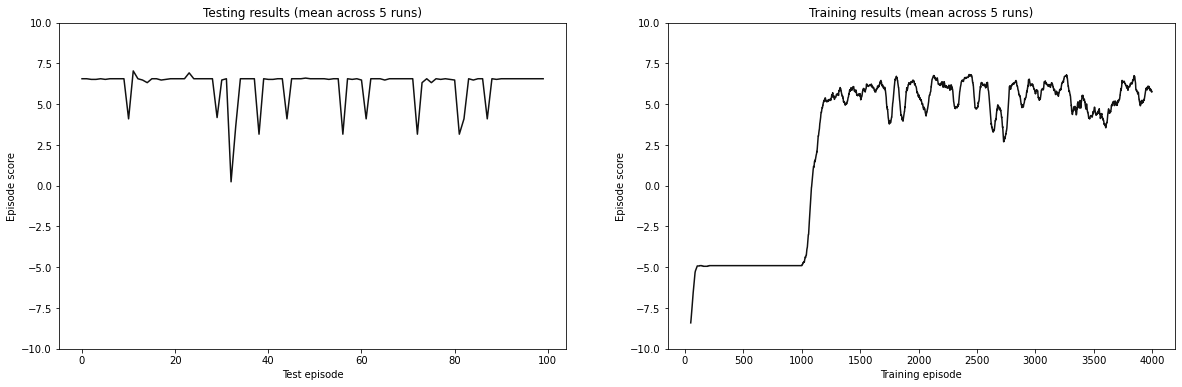

In [14]:
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

window = 50

tests_rewards_np = np.stack(tests_rewards).T
tests_rewards_mean = tests_rewards_np.mean(axis=1)
tests_rewards_std = tests_rewards_np.std(axis=1)
tests_n = list(range(tests_rewards_np.shape[0]))

training_rewards_np = np.stack(training_rewards).T
training_rewards_mean = training_rewards_np.mean(axis=1)
training_rewards_std = training_rewards_np.std(axis=1)
training_n = list(range(training_rewards_np.shape[0]))

axes[0].plot(tests_n, tests_rewards_mean, color="#111111")
# axes[0].fill_between(tests_n, tests_rewards_mean - tests_rewards_std, tests_rewards_mean + tests_rewards_std, color="#DDDDDD")

axes[1].plot(pd.Series(training_rewards_np.mean(axis=1)).rolling(window=window).mean().values, color="#111111")
# axes[1].fill_between(training_n, training_rewards_mean - training_rewards_std, training_rewards_mean + training_rewards_std, color="#DDDDDD")

axes[0].set_title('Testing results (mean across 5 runs)')
axes[0].set_xlabel('Test episode')
axes[0].set_ylabel('Episode score')
axes[0].set_ylim((-10., 10.))

axes[1].set_title('Training results (mean across 5 runs)')
axes[1].set_xlabel('Training episode')
axes[1].set_ylabel('Episode score')
axes[1].set_ylim((-10., 10.))

plt.show()